In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from data_process import tokenizers, utils
from nanoGPT.model import  GPT, GPTConfig
from lightning_training import LightningGPT, GamesDataModule, GamesDataset
import pytorch_lightning as pl
import torch
import os

In [20]:
headers = ["index", "id", "date", "white_elo", "black_elo", "result", "ply", "ply_30s", "piece_uci"]

df = pd.read_csv("./data/csv/train.csv", delimiter=";", header=None, names=headers)

avg_elo = (df["white_elo"] + df["black_elo"]) / 2
df["avg_elo"] = avg_elo
df

,index,id,date,white_elo,black_elo,result,ply,ply_30s,piece_uci,avg_elo
0,9865748,QjOBZIh0,2024.12.04,1744,1697,0-1,46,-1,Pe2e4 39 39 Pe7e6 39 39 Pd2d4 39 39 Pd7d5 39 3...,1720.5
1,9865750,feY65TOZ,2024.12.04,3044,2990,1/2-1/2,148,48,Pd2d3 39 39 Pd7d5 39 39 Pg2g3 39 39 Pe7e5 39 3...,3017.0
2,9865782,fV56oIcJ,2024.12.04,1645,1693,1-0,79,21,Pd2d4 39 39 Pe7e6 39 39 Bc1f4 39 39 Ng8f6 39 3...,1669.0
3,9865783,TT8TVcp1,2024.12.04,1607,1599,1-0,63,-1,Pe2e4 39 39 Pe7e5 39 39 Ng1f3 39 39 Pd7d6 39 3...,1603.0
4,9865784,Bn0SM1cs,2024.12.04,2326,2368,1-0,37,-1,Pg2g3 39 39 Ng8f6 39 39 Bf1g2 39 39 Pe7e5 39 3...,2347.0
...,...,...,...,...,...,...,...,...,...,...
99995,10027123,AoDN4eTI,2024.12.04,960,1009,1-0,27,-1,Pe2e4 39 39 Pe7e5 39 39 Pd2d4 39 39 Pd7d6 39 3...,984.5
99996,10027124,XLKZ0rGS,2024.12.04,1154,1037,1-0,99,93,Pe2e4 39 39 Pd7d5 39 39 Pe4e5 39 39 Pe7e6 39 3...,1095.5
99997,10027125,bbadMpMs,2024.12.04,1505,1539,0-1,34,-1,Pe2e4 39 39 Pe7e5 39 39 Ng1f3 39 39 Pd7d6 39 3...,1522.0
99998,10027126,p20vlsiK,2024.12.04,1908,2058,0-1,130,-1,Pd2d4 39 39 Pd7d5 39 39 Pc2c4 39 39 Pe7e6 39 3...,1983.0


In [5]:
n_games = len(df)
print(f"Number of games: {n_games}")


n_elo_games = len(df[(df.avg_elo >= 0) & (df.avg_elo < 1000)])

print(f"Number of games between 0000 and 1000: ", n_elo_games, "(", n_elo_games/n_games*100, "%)")

step = 200


for elo in range(1000, 4000, step):
    n_elo_games = len(df[(df.avg_elo >= elo) & (df.avg_elo < elo+step)])
    print(f"Number of games between {elo} and {elo+step}: ", n_elo_games, "(", n_elo_games/n_games*100, "%)")
    # print(f"Number of games between {elo} and {elo+100}: ", len(df[(df.avg_elo >= elo) & (df.avg_elo < elo+100)]))

# len(df[(df.avg_elo >= 1000) & (df.avg_elo < 1100)])

Number of games: 100000
Number of games between 0000 and 1000:  5880 ( 5.88 %)
Number of games between 1000 and 1200:  9454 ( 9.454 %)
Number of games between 1200 and 1400:  14558 ( 14.557999999999998 %)
Number of games between 1400 and 1600:  19261 ( 19.261 %)
Number of games between 1600 and 1800:  20962 ( 20.962 %)
Number of games between 1800 and 2000:  17535 ( 17.535 %)
Number of games between 2000 and 2200:  9092 ( 9.092 %)
Number of games between 2200 and 2400:  2468 ( 2.468 %)
Number of games between 2400 and 2600:  660 ( 0.66 %)
Number of games between 2600 and 2800:  97 ( 0.097 %)
Number of games between 2800 and 3000:  14 ( 0.013999999999999999 %)
Number of games between 3000 and 3200:  19 ( 0.019 %)
Number of games between 3200 and 3400:  0 ( 0.0 %)
Number of games between 3400 and 3600:  0 ( 0.0 %)
Number of games between 3600 and 3800:  0 ( 0.0 %)
Number of games between 3800 and 4000:  0 ( 0.0 %)


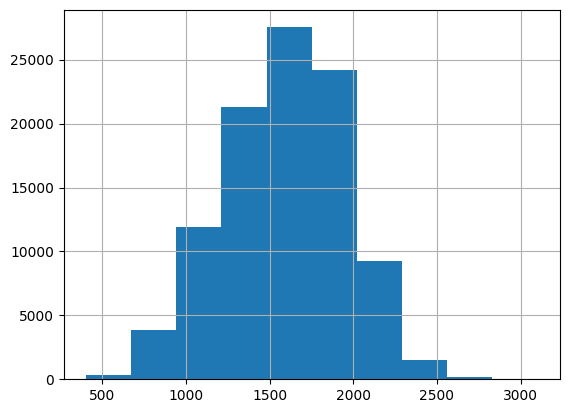

In [6]:
plt.hist(df.avg_elo, bins=10)
plt.grid()
plt.show()

In [32]:
# df = df[df.avg_elo > 2500]

In [ ]:
df['piece_uci'] = utils.remove_material_tokens(df.piece_uci)

,index,id,date,white_elo,black_elo,result,ply,ply_30s,piece_uci,avg_elo
0,9865748,QjOBZIh0,2024.12.04,1744,1697,0-1,46,-1,Pe2e4 Pe7e6 Pd2d4 Pd7d5 Pe4d5 Pe6d5 Ng1f3 Ng8f...,1720.5
1,9865750,feY65TOZ,2024.12.04,3044,2990,1/2-1/2,148,48,Pd2d3 Pd7d5 Pg2g3 Pe7e5 Bf1g2 Ng8f6 Ng1f3 Nb8c...,3017.0
2,9865782,fV56oIcJ,2024.12.04,1645,1693,1-0,79,21,Pd2d4 Pe7e6 Bc1f4 Ng8f6 Pe2e3 Bf8e7 Pc2c3 Nf6e...,1669.0
3,9865783,TT8TVcp1,2024.12.04,1607,1599,1-0,63,-1,Pe2e4 Pe7e5 Ng1f3 Pd7d6 Pc2c3 Nb8c6 Pd2d4 Pf7f...,1603.0
4,9865784,Bn0SM1cs,2024.12.04,2326,2368,1-0,37,-1,Pg2g3 Ng8f6 Bf1g2 Pe7e5 Pd2d3 Pd7d6 Nb1d2 Nb8d...,2347.0
...,...,...,...,...,...,...,...,...,...,...
99995,10027123,AoDN4eTI,2024.12.04,960,1009,1-0,27,-1,Pe2e4 Pe7e5 Pd2d4 Pd7d6 Ng1f3 Ng8f6 Pd4e5 Pd6e...,984.5
99996,10027124,XLKZ0rGS,2024.12.04,1154,1037,1-0,99,93,Pe2e4 Pd7d5 Pe4e5 Pe7e6 Pd2d4 Nb8c6 Ng1f3 Ng8e...,1095.5
99997,10027125,bbadMpMs,2024.12.04,1505,1539,0-1,34,-1,Pe2e4 Pe7e5 Ng1f3 Pd7d6 Ph2h3 Pa7a6 Bf1c4 Nb8c...,1522.0
99998,10027126,p20vlsiK,2024.12.04,1908,2058,0-1,130,-1,Pd2d4 Pd7d5 Pc2c4 Pe7e6 Pe2e3 Ng8f6 Ng1f3 Bf8b...,1983.0


In [33]:
games = utils.remove_material_tokens(df.piece_uci)
games

0        Pe2e4 Pe7e6 Pd2d4 Pd7d5 Pe4d5 Pe6d5 Ng1f3 Ng8f...
1        Pd2d3 Pd7d5 Pg2g3 Pe7e5 Bf1g2 Ng8f6 Ng1f3 Nb8c...
2        Pd2d4 Pe7e6 Bc1f4 Ng8f6 Pe2e3 Bf8e7 Pc2c3 Nf6e...
3        Pe2e4 Pe7e5 Ng1f3 Pd7d6 Pc2c3 Nb8c6 Pd2d4 Pf7f...
4        Pg2g3 Ng8f6 Bf1g2 Pe7e5 Pd2d3 Pd7d6 Nb1d2 Nb8d...
                               ...                        
99995    Pe2e4 Pe7e5 Pd2d4 Pd7d6 Ng1f3 Ng8f6 Pd4e5 Pd6e...
99996    Pe2e4 Pd7d5 Pe4e5 Pe7e6 Pd2d4 Nb8c6 Ng1f3 Ng8e...
99997    Pe2e4 Pe7e5 Ng1f3 Pd7d6 Ph2h3 Pa7a6 Bf1c4 Nb8c...
99998    Pd2d4 Pd7d5 Pc2c4 Pe7e6 Pe2e3 Ng8f6 Ng1f3 Bf8b...
99999    Pd2d4 Ng8f6 Pc2c4 Pe7e6 Ng1f3 Pd7d5 Pe2e3 Nb8d...
Name: piece_uci, Length: 100000, dtype: object

In [34]:
games_with_elo = utils.add_elo_token_to_games(games, df.white_elo, df.black_elo)
games_with_elo

0        1700 1600 Pe2e4 Pe7e6 Pd2d4 Pd7d5 Pe4d5 Pe6d5 ...
1        3000 2900 Pd2d3 Pd7d5 Pg2g3 Pe7e5 Bf1g2 Ng8f6 ...
2        1600 1600 Pd2d4 Pe7e6 Bc1f4 Ng8f6 Pe2e3 Bf8e7 ...
3        1600 1500 Pe2e4 Pe7e5 Ng1f3 Pd7d6 Pc2c3 Nb8c6 ...
4        2300 2300 Pg2g3 Ng8f6 Bf1g2 Pe7e5 Pd2d3 Pd7d6 ...
                               ...                        
99995    900 1000 Pe2e4 Pe7e5 Pd2d4 Pd7d6 Ng1f3 Ng8f6 P...
99996    1100 1000 Pe2e4 Pd7d5 Pe4e5 Pe7e6 Pd2d4 Nb8c6 ...
99997    1500 1500 Pe2e4 Pe7e5 Ng1f3 Pd7d6 Ph2h3 Pa7a6 ...
99998    1900 2000 Pd2d4 Pd7d5 Pc2c4 Pe7e6 Pe2e3 Ng8f6 ...
99999    2200 2200 Pd2d4 Ng8f6 Pc2c4 Pe7e6 Ng1f3 Pd7d5 ...
Length: 100000, dtype: object

In [35]:
tokenizer = tokenizers.FullMoveTokenizerWithElo()
games_without_elo = tokenizer.unk_elo_token + " " + tokenizer.unk_elo_token + " " + games
games_without_elo

0        [UNK_ELO] [UNK_ELO] Pe2e4 Pe7e6 Pd2d4 Pd7d5 Pe...
1        [UNK_ELO] [UNK_ELO] Pd2d3 Pd7d5 Pg2g3 Pe7e5 Bf...
2        [UNK_ELO] [UNK_ELO] Pd2d4 Pe7e6 Bc1f4 Ng8f6 Pe...
3        [UNK_ELO] [UNK_ELO] Pe2e4 Pe7e5 Ng1f3 Pd7d6 Pc...
4        [UNK_ELO] [UNK_ELO] Pg2g3 Ng8f6 Bf1g2 Pe7e5 Pd...
                               ...                        
99995    [UNK_ELO] [UNK_ELO] Pe2e4 Pe7e5 Pd2d4 Pd7d6 Ng...
99996    [UNK_ELO] [UNK_ELO] Pe2e4 Pd7d5 Pe4e5 Pe7e6 Pd...
99997    [UNK_ELO] [UNK_ELO] Pe2e4 Pe7e5 Ng1f3 Pd7d6 Ph...
99998    [UNK_ELO] [UNK_ELO] Pd2d4 Pd7d5 Pc2c4 Pe7e6 Pe...
99999    [UNK_ELO] [UNK_ELO] Pd2d4 Ng8f6 Pc2c4 Pe7e6 Ng...
Name: piece_uci, Length: 100000, dtype: object

In [36]:
elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=8)
no_elo_data_module = GamesDataModule(test_games=list(games_without_elo), tokenizer=tokenizer, num_workers=8)

In [37]:
model_config = GPTConfig(
    block_size=302,
    vocab_size=tokenizer.vocab_size,
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

elo_checkpoint = "./models/elo_training/epoch=4-step=468740.ckpt"
no_elo_checkpoint = "./models/no_elo_training/epoch=4-step=468740.ckpt"

test_start_token = 1

elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=test_start_token)
no_elo_model = LightningGPT.load_from_checkpoint(no_elo_checkpoint, config=model_config, test_start_token=test_start_token)

number of parameters: 27.29M
number of parameters: 27.29M


In [38]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [39]:
trainer.test(elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49848422408103943    │
│         test_loss         │    1.5753401517868042     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5753401517868042, 'test_acc': 0.49848422408103943}]

In [40]:
trainer.test(no_elo_model, datamodule=no_elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49599578976631165    │
│         test_loss         │    1.5673227310180664     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5673227310180664, 'test_acc': 0.49599578976631165}]

In [ ]:
elo_acc = {}
no_elo_acc = {}

for elo in range(500, 3001, 100):
    df_elo = df[(df.avg_elo >= elo) & (df.avg_elo < elo + 100)]
    games = df_elo.piece_uci
    games_with_elo = utils.add_elo_token_to_games(games, df_elo.white_elo, df_elo.black_elo)
    games_without_elo = tokenizer.unk_elo_token + " " + tokenizer.unk_elo_token + " " + games

    elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=8)
    no_elo_data_module = GamesDataModule(test_games=list(games_without_elo), tokenizer=tokenizer, num_workers=8)

    elo_test = trainer.test(elo_model, datamodule=elo_data_module, verbose=False)
    no_elo_test = trainer.test(no_elo_model, datamodule=no_elo_data_module, verbose=False)

    elo_acc[elo] = elo_test[0]["test_acc"]
    no_elo_acc[elo] = no_elo_test[0]["test_acc"]


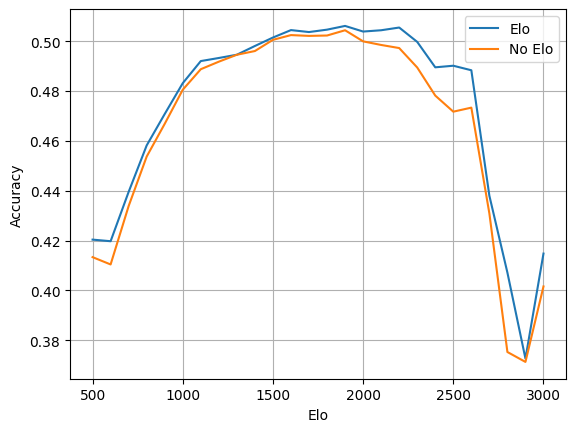

In [55]:
plt.plot(elo_acc.keys(), elo_acc.values(), label="Elo")
plt.plot(no_elo_acc.keys(), no_elo_acc.values(), label="No Elo")
plt.legend()
plt.grid()
plt.xlabel("Elo")
plt.ylabel("Accuracy")
plt.show()

In [57]:
accuracy_df = pd.DataFrame({"elo": list(elo_acc.keys()), "elo_acc": list(elo_acc.values()), "no_elo_acc": list(no_elo_acc.values())})
accuracy_df

,elo,elo_acc,no_elo_acc
0,500,0.420400,0.413365
1,600,0.419760,0.410430
2,700,0.439564,0.433882
3,800,0.458205,0.453732
4,900,0.470823,0.466878
5,1000,0.483187,0.480552
6,1100,0.492062,0.488795
7,1200,0.493298,0.491815
8,1300,0.494608,0.494598
9,1400,0.498114,0.496090
